In [1]:
# Import standard libraries
import os

# Third-Party Libraries
import numpy as np
import matplotlib.pyplot as plt

# Import the Swarm Systems Lab Simulator
from ssl_simulator import SimulationEngine
from ssl_simulator.robot_models import SingleIntegrator, Unicycle2D
from ssl_simulator.gvf_trajectories import GvfLineAB
from ssl_simulator.data_manager import load_sim
from ssl_simulator.visualization import set_paper_parameters
set_paper_parameters(fontsize=15)

# Import custom functions and classes
from visualization import PlotFormation, PlotInterp, PlotGvfIkCons
from controllers import Oscillator, GvfIKCons

# Define constants for file paths
OUTPUT_DIR = os.path.join("..", "output")
SIMDATA_FILE = os.path.join(OUTPUT_DIR, "data_paper.csv")

# Some paper plots

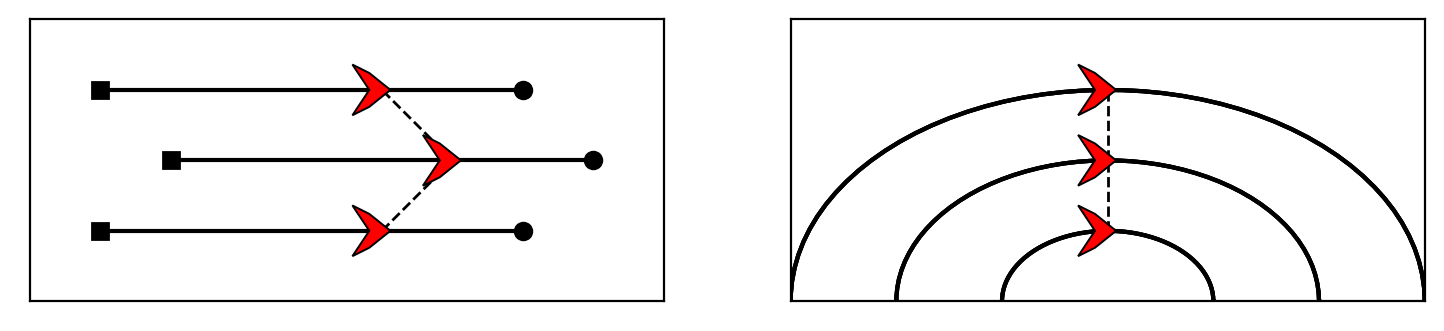

In [2]:
# Initialize the plotter with the loaded simulation data
plotter = PlotFormation(figsize=(9,3), dpi=200)

# Generate and display the plot
plotter.plot()
plt.show()

# Numerical estimation of $A(\dot{\bar x})$ for different $\omega$

In [3]:
# Plot parameters ---------------
N = 10 # robots per omega

speed = 16
omega_list = [2*np.pi, np.pi, np.pi/2, np.pi/4, np.pi/8]
# -------------------------------

In [4]:
N_omega = N * len(omega_list)

# Define the initial state
p = np.ones((N_omega,2)) * np.array([[0,0]])
x0 = [p]

# Controller settings
speed_sim = np.ones((N_omega)) * np.array([speed])

omega_sim = np.ones(N_omega)
A_sim = np.ones(N_omega)
for i,omega in enumerate(omega_list):
    omega_sim[i*N:(i+1)*N] = omega
    A_sim[i*N:(i+1)*N] = np.linspace(0, speed/omega*0.999999, N)

# --------------------------------
# Select and initialize the robot model and the controller
robot_model = SingleIntegrator(x0)
controller = Oscillator(A_sim, omega_sim, speed_sim)


# Then, construct the Simulator Engine
dt = 0.002
simulator = SimulationEngine(robot_model, controller, time_step=dt, log_filename=SIMDATA_FILE)

# --------------------------------
# Run the simulation and save data
tf = 2*np.pi / np.min(omega_list) * 1.2

simulator.run(tf)

Running simulation:   0%|          | 0/9600 [00:00<?, ?it/s]

Running simulation: 100%|██████████| 9600/9600 [00:07<00:00, 1303.11it/s]


omega = 6.28 --> a = 1.35, sigma = 0.0136
omega = 3.14 --> a = 1.35, sigma = 0.0136
omega = 1.57 --> a = 1.35, sigma = 0.0137
omega = 0.79 --> a = 1.35, sigma = 0.0137
omega = 0.39 --> a = 1.35, sigma = 0.0137


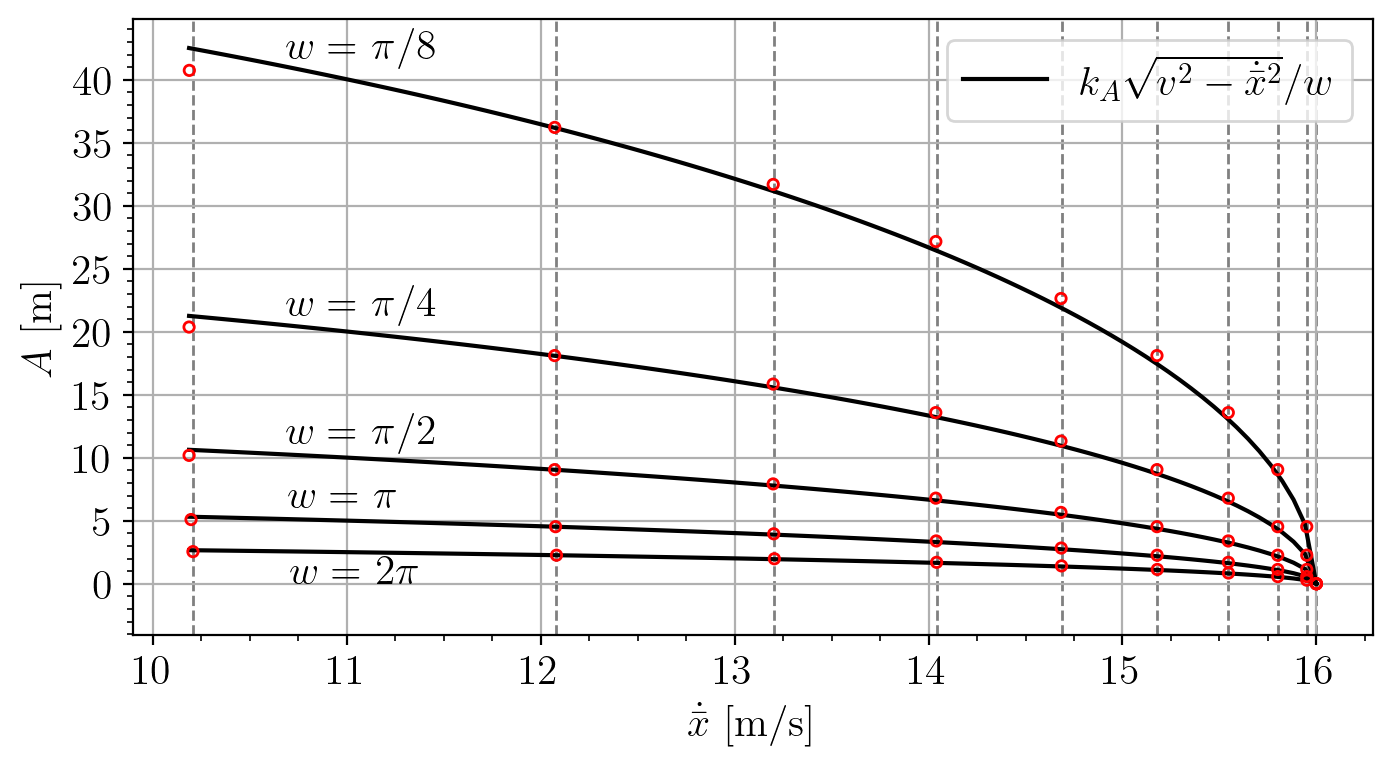

In [5]:
# Load previously saved simulation data from the specified file
simulation_data = load_sim(SIMDATA_FILE, debug=False)

x_dot = np.array(simulation_data["p_dot"].tolist())[:,:,0]

# Initialize the plotter with the loaded simulation data
plotter = PlotInterp(simulation_data, N, dpi=200, figsize=(8,4))

# Generate and display the plot
ax = plotter.plot()
plt.show()

In [6]:
# Save the plot as a file with the desired resolution
plotter.save(os.path.join(OUTPUT_DIR, "Axdot_h.png"), dpi=200)

# Simulation with many agents

In [7]:
# --------------------------------
# Define the initial state

# Number of agents
N = 8

# Initial position of the lines
line_x0 = np.zeros(N)
line_y0 = np.linspace(0,160,N)

# Initial stata of the robots
p = np.array([line_x0 + np.random.random(N)*100, line_y0 + np.random.random(N)*20]).T
p[0,1] = p[0,1] - 20 
p[-1,1] = p[-1,1] + 30 

np.random.seed(1234)
np.random.shuffle(p[:,1])

speed = np.ones((N)) * np.array([8])
theta = np.zeros((N)) + 2 * (np.random.random(N) - 0.5) * np.pi/2

# p = regpoly_formation(N,50)
# p[:,0] = p[:,0] + 35
# p[:,1] = p[:,1] + 80
# speed = np.ones((N)) * np.array([8])
# theta = np.ones((N)) * np.array([0])

x0 = [p, speed, theta]

# Conectivity graph
Z = [[0,1],[1,2],[2,3],[2,4],[3,5],[4,6],[5,7]]

# --------------------------------
# Controller settings
A = np.array([0,8,16])
omega = np.ones((N)) * 0.6
ka = 0.14

# --------------------------------
# Generate the trajectory to be followed
l = 1000
heading = 0

points_A = np.array([line_x0, line_y0]).T
points_B = np.array([line_x0 + l*np.cos(heading), line_y0 + l*np.sin(heading)]).T

gvf_traj = []
for i in range(N):
    gvf_traj.append(GvfLineAB(points_A[i], points_B[i]))

# Select the robot model
robot_model = Unicycle2D(x0, omega_lims=[-np.pi/4, np.pi/4])

# Initialize the controller
s, ke, kn = 1, 0.18, 1
controller = GvfIKCons(gvf_traj, Z, s, ke, kn, omega, ka)


# Then, construct the Simulator Engine
dt = 0.01
simulator = SimulationEngine(robot_model, controller, time_step=dt, log_filename=SIMDATA_FILE)
    
# --------------------------------
# Run the simulation and save data
tf = 120

simulator.run(tf)
# --------------------------------

Running simulation:   0%|          | 0/12000 [00:00<?, ?it/s]

Running simulation: 100%|██████████| 12000/12000 [00:10<00:00, 1126.70it/s]


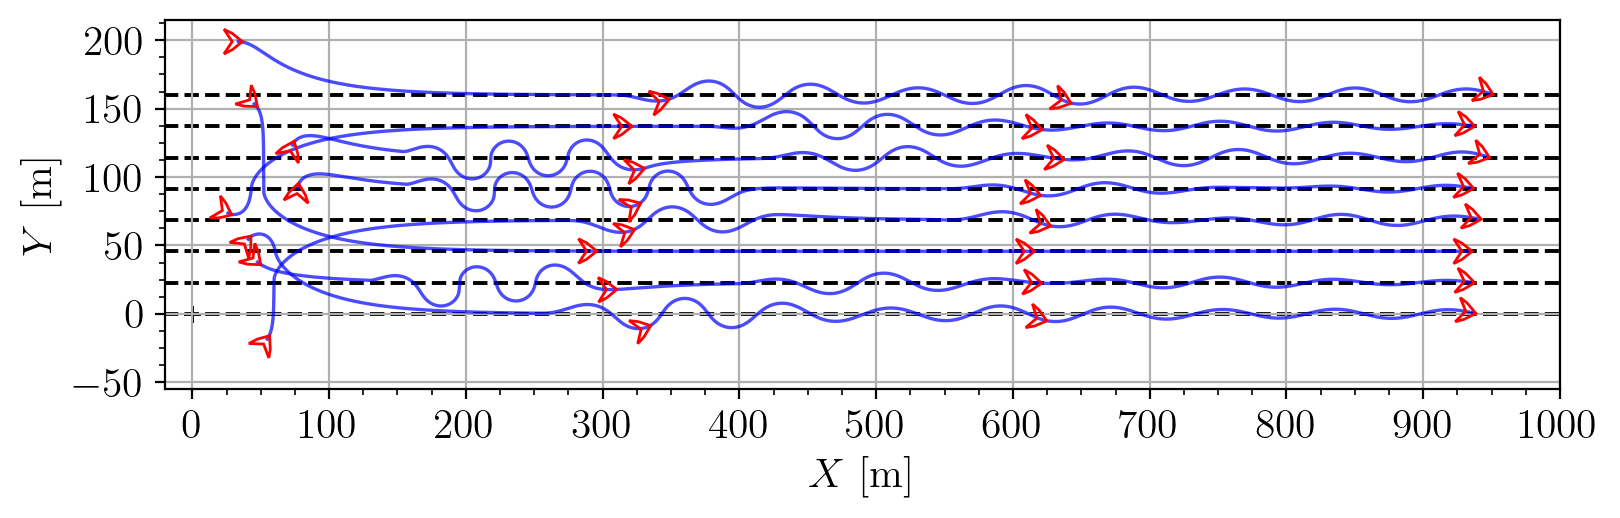

In [8]:
# Load previously saved simulation data from the specified file
simulation_data = load_sim(SIMDATA_FILE, debug=False)

# Initialize the plotter with the loaded simulation data
plotter = PlotGvfIkCons(simulation_data, gvf_traj, size=15, lw=1, figsize=(9,3), dpi=200)

# Generate and display the plot
ax = plotter.plot(lw=1.2, alpha=0.7, num_patches=4)
ax.set_xlim([-20, l])
ax.set_ylim([-55,215])

plt.show()